In [7]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow as tf
import pandas as pd
from keras import models, optimizers, backend
from keras.layers import core, convolutional, pooling
from sklearn import model_selection
#from preprocess.imageSteeringDB import ImageSteeringDB
import cv2
import random

local_project_path = r'C:/Users/Ketan/Thesis/PilotNet/src/driving_dataset/'
local_data_path = os.path.join(local_project_path, 'C:/Users/Ketan/Thesis/PilotNet/src/driving_dataset')
from tensorflow.keras.utils import Sequence
import matplotlib.image as mpimg

import os, json
import matplotlib.pyplot as plt

from PIL import Image
import skimage 
from skimage.transform import resize

from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from sklearn.preprocessing import LabelEncoder


from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
from lime import lime_image

from keras.applications import inception_v3 as inc_net
from keras.applications.imagenet_utils import decode_predictions




In [53]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 356458341547129125
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2381978824
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3150787284471211654
physical_device_desc: "device: 0, name: NVIDIA GeForce MX130, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [54]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

AttributeError: module 'keras.backend' has no attribute 'tensorflow_backend'

In [19]:
dataset = ('C:/Users/Ketan/Thesis/PilotNet/src/driving_dataset')

In [20]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
img = get_image('./driving_dataset/481.jpg')


In [21]:
#plt.imshow(img)

In [22]:
# img1 = Image.open('./driving_dataset/481.jpg')

In [23]:
# img1 = np.array(img1)

In [24]:
#plt.imshow(img1)

In [25]:
# Read the data
df = pd.io.parsers.read_csv(os.path.join(dataset, 'data_new.csv'))
# Split data into training and validation sets
df_train, df_valid = model_selection.train_test_split(df, test_size=.2)

In [26]:
x_train = df['image']
y_train = df['angle']

In [27]:
df['angle'].describe()


count    45405.000000
mean         1.745390
std         30.915841
min       -159.900000
25%         -5.450000
50%          1.010000
75%          8.870000
max        501.780000
Name: angle, dtype: float64

In [28]:
#df_train['angle'].nlargest(20)


In [29]:
# q_low = df["angle"].quantile(0.01)
# q_hi  = df["angle"].quantile(0.99)
# q_low, q_hi

In [30]:
# cats, bins1 = pd.cut(df.angle, 5, retbins=True)


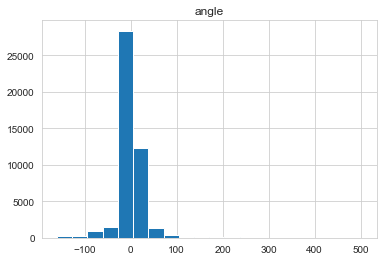

In [31]:
import seaborn as sns
sns.set_style('whitegrid')
hist = df.hist(bins=20)

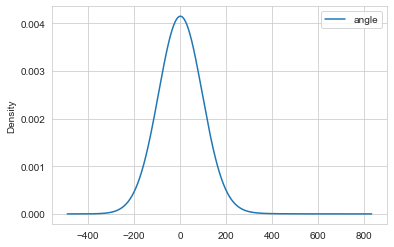

In [32]:
ax = df.plot.kde(bw_method=3)


In [33]:
pd.options.mode.chained_assignment = None #default = warn

In [34]:
df_train['angle_range'] = pd.qcut(df_train['angle'], q=10)
df_valid['angle_range'] = pd.qcut(df_valid['angle'], q=10)

In [35]:
df_train['labels']= df_train['angle_range'].cat.codes
df_valid['labels']= df_valid['angle_range'].cat.codes

In [36]:
df_train['labels'] = df_train['labels'].apply(str)
df_valid['labels'] = df_valid['labels'].apply(str)


In [52]:
# df_train.angle_range
#Categories (10, interval[float64]): [(-159.901, -18.76] < (-18.76, -9.48] < (-9.48, -2.52] < (-2.52, 0.0] ... (2.42, 6.25] 
                                    #< (6.25, 11.5] < (11.5, 22.08] < (22.08, 501.78]]

In [38]:
datagen=ImageDataGenerator(rescale=1./255)
train_generator=datagen.flow_from_dataframe(dataframe=df_train, directory=dataset, x_col="image", y_col="labels", 
                                            class_mode="categorical", target_size=(455,256), batch_size=32)

Found 36324 validated image filenames belonging to 10 classes.


In [40]:
valid_generator=datagen.flow_from_dataframe(dataframe=df_valid, directory=dataset, 
                                            x_col="image", y_col="labels", class_mode="categorical", target_size=(455,256), 
                                            batch_size=32)

Found 9081 validated image filenames belonging to 10 classes.


In [ ]:
#Transfer learning with resnet50

In [1]:
from tensorflow.keras.applications.resnet50 import ResNet50


In [3]:
base_model = ResNet50(weights='imagenet',input_shape=(455,256,3),include_top=False)


94781440/94765736 [==============================] - 6s 0us/step


In [4]:
base_model.trainable = False

In [50]:
model = models.Sequential()
model.add(base_model)
model.add(core.Flatten())
model.add(core.Dense(512, activation='relu'))
model.add(core.Dense(256, activation='relu'))
model.add(core.Dense(64, activation='relu'))
model.add(core.Dense(10, activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-04), loss='categorical_crossentropy',metrics=['AUC', 'categorical_accuracy'],)

In [48]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

In [51]:
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=2)

Epoch 1/2


 113/1135 [=>............................] - ETA: 3:04:56 - loss: 2.6857 - auc: 0.4630 - categorical_accuracy: 0.093 - ETA: 38:12 - loss: 4.7072 - auc: 0.4581 - categorical_accuracy: 0.0781  - ETA: 38:08 - loss: 5.1007 - auc: 0.4625 - categorical_accuracy: 0.083 - ETA: 38:05 - loss: 5.2092 - auc: 0.4725 - categorical_accuracy: 0.101 - ETA: 38:02 - loss: 4.8201 - auc: 0.4903 - categorical_accuracy: 0.112 - ETA: 38:01 - loss: 4.4479 - auc: 0.5121 - categorical_accuracy: 0.114 - ETA: 37:58 - loss: 4.3138 - auc: 0.5162 - categorical_accuracy: 0.111 - ETA: 37:57 - loss: 4.1470 - auc: 0.5208 - categorical_accuracy: 0.105 - ETA: 37:54 - loss: 3.9901 - auc: 0.5233 - categorical_accuracy: 0.104 - ETA: 37:52 - loss: 3.8951 - auc: 0.5204 - categorical_accuracy: 0.103 - ETA: 37:50 - loss: 3.8099 - auc: 0.5177 - categorical_accuracy: 0.096 - ETA: 37:47 - loss: 3.7095 - auc: 0.5156 - categorical_accuracy: 0.091 - ETA: 37:45 - loss: 3.6190 - auc: 0.5148 - categorical_accuracy: 0.086 - ETA: 37:43 - lo

 569/1135 [==============>...............] - ETA: 23:59 - loss: 2.3022 - auc: 0.6112 - categorical_accuracy: 0.184 - ETA: 23:57 - loss: 2.3019 - auc: 0.6114 - categorical_accuracy: 0.184 - ETA: 23:55 - loss: 2.3013 - auc: 0.6116 - categorical_accuracy: 0.184 - ETA: 23:53 - loss: 2.3007 - auc: 0.6118 - categorical_accuracy: 0.185 - ETA: 23:51 - loss: 2.3001 - auc: 0.6121 - categorical_accuracy: 0.185 - ETA: 23:49 - loss: 2.3003 - auc: 0.6120 - categorical_accuracy: 0.185 - ETA: 23:47 - loss: 2.3006 - auc: 0.6120 - categorical_accuracy: 0.184 - ETA: 23:45 - loss: 2.3008 - auc: 0.6119 - categorical_accuracy: 0.184 - ETA: 23:43 - loss: 2.3007 - auc: 0.6119 - categorical_accuracy: 0.185 - ETA: 23:41 - loss: 2.3008 - auc: 0.6118 - categorical_accuracy: 0.184 - ETA: 23:39 - loss: 2.3003 - auc: 0.6120 - categorical_accuracy: 0.185 - ETA: 23:37 - loss: 2.2999 - auc: 0.6121 - categorical_accuracy: 0.185 - ETA: 23:35 - loss: 2.2992 - auc: 0.6124 - categorical_accuracy: 0.185 - ETA: 23:32 - loss: 

 683/1135 [=================>............] - ETA: 20:02 - loss: 2.2712 - auc: 0.6211 - categorical_accuracy: 0.192 - ETA: 20:00 - loss: 2.2710 - auc: 0.6211 - categorical_accuracy: 0.192 - ETA: 19:58 - loss: 2.2704 - auc: 0.6214 - categorical_accuracy: 0.192 - ETA: 19:56 - loss: 2.2700 - auc: 0.6215 - categorical_accuracy: 0.192 - ETA: 19:54 - loss: 2.2700 - auc: 0.6215 - categorical_accuracy: 0.192 - ETA: 19:52 - loss: 2.2698 - auc: 0.6215 - categorical_accuracy: 0.192 - ETA: 19:50 - loss: 2.2694 - auc: 0.6216 - categorical_accuracy: 0.192 - ETA: 19:48 - loss: 2.2693 - auc: 0.6217 - categorical_accuracy: 0.192 - ETA: 19:46 - loss: 2.2688 - auc: 0.6218 - categorical_accuracy: 0.192 - ETA: 19:44 - loss: 2.2681 - auc: 0.6221 - categorical_accuracy: 0.193 - ETA: 19:41 - loss: 2.2674 - auc: 0.6224 - categorical_accuracy: 0.193 - ETA: 19:39 - loss: 2.2674 - auc: 0.6224 - categorical_accuracy: 0.193 - ETA: 19:37 - loss: 2.2671 - auc: 0.6225 - categorical_accuracy: 0.193 - ETA: 19:35 - loss: 

 797/1135 [====================>.........] - ETA: 16:06 - loss: 2.2595 - auc: 0.6267 - categorical_accuracy: 0.198 - ETA: 16:04 - loss: 2.2594 - auc: 0.6267 - categorical_accuracy: 0.198 - ETA: 16:01 - loss: 2.2592 - auc: 0.6268 - categorical_accuracy: 0.198 - ETA: 15:59 - loss: 2.2589 - auc: 0.6269 - categorical_accuracy: 0.198 - ETA: 15:57 - loss: 2.2585 - auc: 0.6271 - categorical_accuracy: 0.198 - ETA: 15:55 - loss: 2.2583 - auc: 0.6272 - categorical_accuracy: 0.198 - ETA: 15:53 - loss: 2.2580 - auc: 0.6273 - categorical_accuracy: 0.198 - ETA: 15:51 - loss: 2.2584 - auc: 0.6272 - categorical_accuracy: 0.198 - ETA: 15:49 - loss: 2.2587 - auc: 0.6271 - categorical_accuracy: 0.198 - ETA: 15:47 - loss: 2.2585 - auc: 0.6271 - categorical_accuracy: 0.198 - ETA: 15:45 - loss: 2.2586 - auc: 0.6271 - categorical_accuracy: 0.198 - ETA: 15:43 - loss: 2.2583 - auc: 0.6272 - categorical_accuracy: 0.198 - ETA: 15:41 - loss: 2.2582 - auc: 0.6272 - categorical_accuracy: 0.198 - ETA: 15:39 - loss: 

 912/1135 [=======================>......] - ETA: 12:06 - loss: 2.2388 - auc: 0.6338 - categorical_accuracy: 0.203 - ETA: 12:04 - loss: 2.2386 - auc: 0.6339 - categorical_accuracy: 0.203 - ETA: 12:02 - loss: 2.2387 - auc: 0.6339 - categorical_accuracy: 0.203 - ETA: 12:00 - loss: 2.2382 - auc: 0.6340 - categorical_accuracy: 0.203 - ETA: 11:58 - loss: 2.2380 - auc: 0.6341 - categorical_accuracy: 0.204 - ETA: 11:56 - loss: 2.2378 - auc: 0.6342 - categorical_accuracy: 0.204 - ETA: 11:54 - loss: 2.2375 - auc: 0.6344 - categorical_accuracy: 0.204 - ETA: 11:52 - loss: 2.2372 - auc: 0.6345 - categorical_accuracy: 0.204 - ETA: 11:49 - loss: 2.2371 - auc: 0.6345 - categorical_accuracy: 0.204 - ETA: 11:47 - loss: 2.2369 - auc: 0.6345 - categorical_accuracy: 0.204 - ETA: 11:45 - loss: 2.2367 - auc: 0.6346 - categorical_accuracy: 0.204 - ETA: 11:43 - loss: 2.2366 - auc: 0.6347 - categorical_accuracy: 0.204 - ETA: 11:41 - loss: 2.2365 - auc: 0.6347 - categorical_accuracy: 0.204 - ETA: 11:39 - loss: 

1029/1135 [==========================>...] - ETA: 8:01 - loss: 2.2178 - auc: 0.6425 - categorical_accuracy: 0.21 - ETA: 7:59 - loss: 2.2176 - auc: 0.6425 - categorical_accuracy: 0.21 - ETA: 7:56 - loss: 2.2173 - auc: 0.6426 - categorical_accuracy: 0.21 - ETA: 7:54 - loss: 2.2172 - auc: 0.6426 - categorical_accuracy: 0.21 - ETA: 7:52 - loss: 2.2169 - auc: 0.6428 - categorical_accuracy: 0.21 - ETA: 7:50 - loss: 2.2167 - auc: 0.6428 - categorical_accuracy: 0.21 - ETA: 7:48 - loss: 2.2166 - auc: 0.6429 - categorical_accuracy: 0.21 - ETA: 7:46 - loss: 2.2161 - auc: 0.6431 - categorical_accuracy: 0.21 - ETA: 7:44 - loss: 2.2160 - auc: 0.6432 - categorical_accuracy: 0.21 - ETA: 7:41 - loss: 2.2156 - auc: 0.6433 - categorical_accuracy: 0.21 - ETA: 7:39 - loss: 2.2154 - auc: 0.6434 - categorical_accuracy: 0.21 - ETA: 7:37 - loss: 2.2154 - auc: 0.6433 - categorical_accuracy: 0.21 - ETA: 7:35 - loss: 2.2150 - auc: 0.6435 - categorical_accuracy: 0.21 - ETA: 7:33 - loss: 2.2148 - auc: 0.6436 - cate

1099/1135 [============================>.] - ETA: 3:48 - loss: 2.1970 - auc: 0.6508 - categorical_accuracy: 0.21 - ETA: 3:46 - loss: 2.1968 - auc: 0.6509 - categorical_accuracy: 0.21 - ETA: 3:44 - loss: 2.1965 - auc: 0.6510 - categorical_accuracy: 0.21 - ETA: 3:41 - loss: 2.1961 - auc: 0.6512 - categorical_accuracy: 0.21 - ETA: 3:39 - loss: 2.1959 - auc: 0.6513 - categorical_accuracy: 0.21 - ETA: 3:37 - loss: 2.1959 - auc: 0.6513 - categorical_accuracy: 0.21 - ETA: 3:35 - loss: 2.1958 - auc: 0.6513 - categorical_accuracy: 0.21 - ETA: 3:33 - loss: 2.1957 - auc: 0.6514 - categorical_accuracy: 0.21 - ETA: 3:31 - loss: 2.1955 - auc: 0.6515 - categorical_accuracy: 0.21 - ETA: 3:28 - loss: 2.1952 - auc: 0.6516 - categorical_accuracy: 0.21 - ETA: 3:26 - loss: 2.1948 - auc: 0.6518 - categorical_accuracy: 0.21 - ETA: 3:24 - loss: 2.1948 - auc: 0.6518 - categorical_accuracy: 0.21 - ETA: 3:22 - loss: 2.1945 - auc: 0.6518 - categorical_accuracy: 0.21 - ETA: 3:20 - loss: 2.1944 - auc: 0.6519 - cate

KeyboardInterrupt: 

SyntaxError: invalid syntax (<ipython-input-1-0b69cd9bf01e>, line 1)

In [ ]:
# backend.clear_session()

In [ ]:
# Cameras we will use
# cameras = ['left', 'center', 'right']
# cameras_steering_correction = [.25, 0., -.25]

def preprocess(image, top_offset=.1, bottom_offset=.1):
    """
    Applies preprocessing pipeline to an image: crops `top_offset` and `bottom_offset`
    portions of image, resizes to 32x128 px (from 160×320 in original repo) and scales pixel values to [0, 1].
    """
    top = int(top_offset * image.shape[0])
    bottom = int(bottom_offset * image.shape[0])
    image = skimage.transform.resize(image[top:-bottom, :], (455, 256, 3), mode='constant')
    return image

def generate(data, root_path, augment=True):
    """
    Keras generator yielding batches of training/validation data.
    Applies data augmentation pipeline if `augment` is True.
    """
    #print('hello')
    while True:
        # Generate random batch of indices
        indices = np.random.permutation(data.count()[0])
        batch_size = 128
        for batch in range(0, len(indices), batch_size):
            batch_indices = indices[batch:(batch + batch_size)]
            # Output arrays
            x = np.empty([0, 455, 256, 3], dtype=np.float32)
            y = np.empty([0], dtype=np.float32)
            # Read in and preprocess a batch of images
            for i in batch_indices:
                # Randomly select camera
                #camera = np.random.randint(len(cameras)) if augment else 1
                # Read frame image and work out steering angle
                
                #print(data.values[1])
                image = Image.open(root_path + data.values[i][0])#.clip(' '))
                image = np.array(image)
                #print(image)
                angle = data.angle.values[i]
                if augment:
                    # Add random shadow as a vertical slice of image
                    #print( image.shape[0])
                    h, w = image.shape[0], image.shape[1]
                    [x1, x2] = np.random.choice(w, 2, replace=False)
                    k = h / (x2 - x1)
                    b = - k * x1
                    for i in range(h):
                        c = int((i - b) / k)
                        image[i, :c, :] = (image[i, :c, :] * .5).astype(np.int32)
                # Randomly shift up and down while preprocessing
                v_delta = .05 if augment else 0
                image = preprocess(
                    image,
                    top_offset=random.uniform(.375 - v_delta, .375 + v_delta),
                    bottom_offset=random.uniform(.125 - v_delta, .125 + v_delta)
                )
                # Append to batch
                x = np.append(x, [image], axis=0)
                y = np.append(y, [angle])
            # Randomly flip half of images in the batch
            flip_indices = random.sample(range(x.shape[0]), int(x.shape[0] / 2))
            x[flip_indices] = x[flip_indices, :, ::-1, :]
            y[flip_indices] = -y[flip_indices]
            yield (x, y)

In [ ]:
#generate(df_train, local_project_path)

In [ ]:
history = model.fit_generator(
    generate(df_train, local_project_path), steps_per_epoch=df_train.shape[0], epochs=1, 
    validation_data=generate(df_valid, local_project_path, augment=False), validation_steps=df_valid.shape[0],
)

In [ ]:
model.fit(
    x=generate(df_train, local_project_path), y=None, batch_size=None, epochs=1, verbose='auto',
    callbacks=None, validation_split=0.0, validation_data=None, shuffle=True,
    class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None,
    validation_steps=None, validation_batch_size=None, validation_freq=1,
    max_queue_size=10, workers=1, use_multiprocessing=False
)